In [18]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import pickle


import psutil
psutil.cpu_count()
p = psutil.Process()
p.cpu_affinity([0,1,2,3])

os.chdir(r'H:\all\RL_Shrinkage_2024')
from helpers import helper_functions as hf
from ONE_YR.NonLinear_Shrinkage import regression_evaluation_funcs as re_hf
from helpers import eval_function_new


#### Load Data for Cov1Para!!

In [94]:
PF_SIZE = 500


base_folder_path = r'H:\\all\\RL_Shrikage_2024'
# IMPORT SHRK DATASETS
pf_size = PF_SIZE  # DONT CHANGE HERE!!
permnos = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\permnos_1Y_p{pf_size}.pickle")
rets_full = pd.read_pickle(
    fr"{base_folder_path}\ONE_YR\preprocessing\rets_permnos_1Y\returns_full_1Y_p{pf_size}.pickle")


fixed_shrk_name = 'cov1Para'
opt_shrk_name = 'cov1Para'
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    fixed_shrk_data = pickle.load(f)
with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\{opt_shrk_name}_factor-1.0_p{pf_size}.pickle", 'rb') as f:
    optimal_shrk_data = pickle.load(f)

with open(rf"{base_folder_path}\ONE_YR\preprocessing\training_dfs\PF{pf_size}\fixed_shrkges_rawres_{fixed_shrk_name}_p{pf_size}.pickle", 'rb') as f:
    rawres_fixed_shrk_data = pickle.load(f)

# IMPORT FACTORS DATA AND PREPARE FOR FURTHER USE
factor_path = fr"{base_folder_path}\helpers"
factors = pd.read_csv(factor_path + "/all_factors.csv")
factors = factors.pivot(index="date", columns="name", values="ret")

# as our shrk data starts from 1980-01-15 our factors data should too
start_date = str(optimal_shrk_data['date'].iloc[0])
start_date = start_date[0:4] + '-' + start_date[4:6] + "-" + start_date[6:]
start_idx = np.where(factors.index == start_date)[0][0]
factors = factors.iloc[start_idx:start_idx+fixed_shrk_data.shape[0], :]

In [95]:
cov1para_shrk = optimal_shrk_data['shrk_factor'].values[5040:]

len_train = 5040
end_date = fixed_shrk_data.shape[0]
val_indices_correct = (len_train, end_date)
val_indices_results = [val_indices_correct[0] + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]
val_idxes_shrkges = [0 + 21 * i for i in range((val_indices_correct[-1] - val_indices_correct[0]) // 21)]

In [134]:
all_res = fixed_shrk_data.iloc[:, 2:].copy() * 100
all_factors = all_res.columns.astype(float).values
Y = all_res.idxmin(axis=1).values.astype(float)
opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values


ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt = pd.Series(opt_values).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

Y = pd.Series(Y).rolling(window=1, min_periods=1).mean().astype(np.int64).values
opt_values = pd.Series(opt_values).rolling(window=1, min_periods=1).mean().astype(np.int64).values



In [135]:
params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2, optimal_shrk_data['shrk_factor'].values.astype(np.float64)*100]  
}

X = re_hf.load_additional_train_data(**params)

### Training with base params as for NL

np.float64(10.450844931287437)

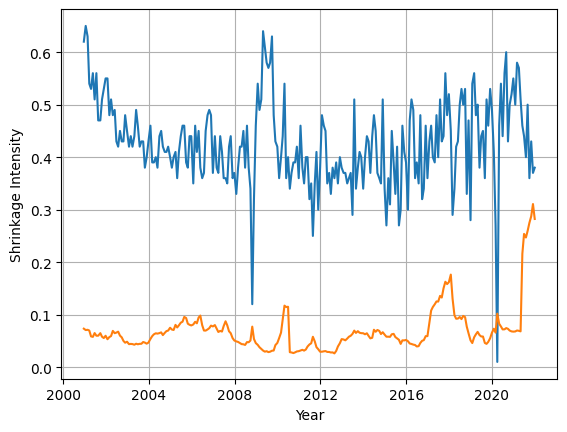

In [136]:
res = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=5040, 
                                                    model_params={})
res = [r if r > 0 else 0 for r in res]
res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]

mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res ]).std()*np.sqrt(252)*100

In [116]:
x = [x-0.1 if x-0.1 > 0 else 0.2 for x in mapped_res]
x = [x if x > 0.3 else 0.2 for x in x]

In [119]:
x2 =  [x if x > 0.3 else 0.2 for x in mapped_res]

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, x2 ]).std()*np.sqrt(252)*100

np.float64(10.429646382786068)

In [ ]:
rawres_fixed_shrk_data.iloc[5040:, :]

### Testing weighted objectives

In [120]:
c1p = optimal_shrk_data['shrk_factor'].values.astype(np.float64)
c1p

array([0.07422711, 0.07388982, 0.07363839, ..., 0.05837805, 0.05833074,
       0.05828171])

In [78]:
fixed_shrk_data


array([0.07422711, 0.07388982, 0.07363839, 0.0730085 , 0.07295891,
       0.07288839, 0.0734518 , 0.07230578, 0.07227931, 0.0727235 ])

np.float64(10.450844931287437)

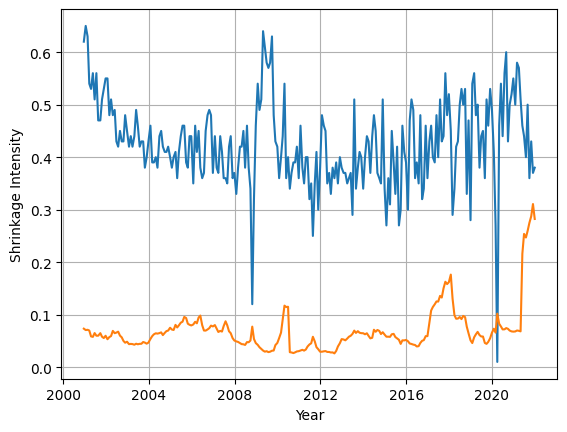

In [146]:
all_res = fixed_shrk_data.iloc[:, 2:].copy() * 100
all_factors = all_res.columns.astype(float).values
Y = all_res.idxmin(axis=1).values.astype(float)
opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))

Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values


ROLL_WINDOW = 1
ROLL_WINDOW_INPUTS = 252
rolling_opt = pd.Series(opt_values).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

Y = pd.Series(Y).rolling(window=1, min_periods=1).mean().astype(np.int64).values
opt_values = pd.Series(opt_values).rolling(window=1, min_periods=1).mean().astype(np.int64).values

# Y = np.round(Y*0.6 + 0.4* np.repeat(0.3, Y.shape[0]) *100, 0)



params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2, optimal_shrk_data['shrk_factor']*100]  
}

X = re_hf.load_additional_train_data(**params)

res = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=5040, 
                                                    model_params={})
res = [r if r > 0 else 0 for r in res]
res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]

mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

### Create Ex Post Grids and Save Them (find best ex post level)

In [195]:
np.mean(mapped_res - np.mean(mapped_res) + 0.3 )

np.mean((mapped_res) * 0.3/np.mean(mapped_res))




np.float64(0.30000000000000004)

In [201]:
np.mean(mapped_res*(0.3/np.mean(mapped_res)))

np.float64(0.3)

In [206]:
np.mean(np.round(mapped_res* (0.1/np.mean(mapped_res)), 2))

np.float64(0.09980237154150198)

In [213]:
0.7/np.mean(mapped_res)

np.float64(1.6395112016293276)

np.float64(10.388709911287174)

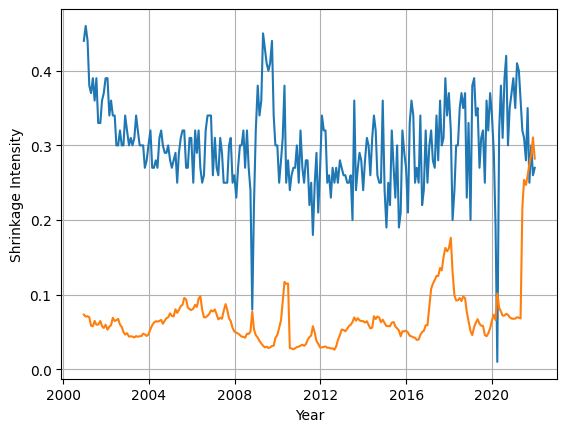

In [218]:

a = 0.2

#x = (np.round((mapped_res * (1-a) + 0.3 * a), 2))

x = np.round(mapped_res* (0.3/np.mean(mapped_res)), 2)
x = [x if x<1 else 1 for x in x]

#x = np.round(mapped_res - np.mean(mapped_res) + 0.3, 2)
#x = [x if x>0 else 0 for x in x]



res_df = pd.DataFrame({"ElasticNet_CVC": x, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, x]).std()*np.sqrt(252)*100

In [81]:
np.diag(rawres_fixed_shrk_data.iloc[5040+252:, :].loc[:, mapped_res[252:]]).std()*np.sqrt(252)*100

np.float64(10.375120814105939)

In [83]:
px.line((rawres_fixed_shrk_data.iloc[5040+252:].std()*np.sqrt(252)*100))

### Training with different params to achieve nicer model

np.float64(10.424272833620032)

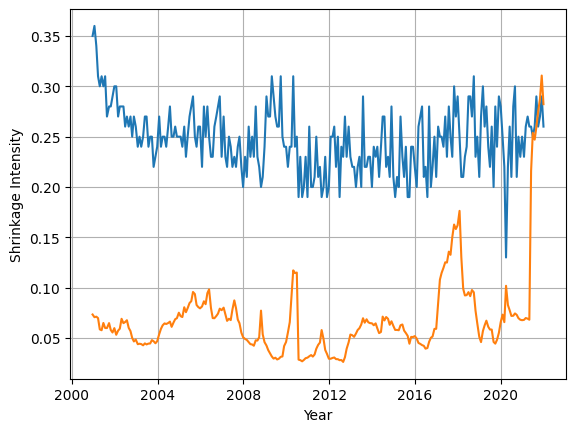

In [132]:
res = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=5040, 
                                                    model_params={
                                                        'alpha': 5,
                                                        'max_iter': 1000,
                                                        'tol': 1e-4,
                                                        'l1_ratio': 0.5,
                                                        'fit_intercept': True,
                                                    })
res = [r if r > 0 else 0 for r in res]
res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]

mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

In [27]:
np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

np.float64(10.593770141623583)

### Train with rolling Y as signal

np.float64(28.962856094990062)

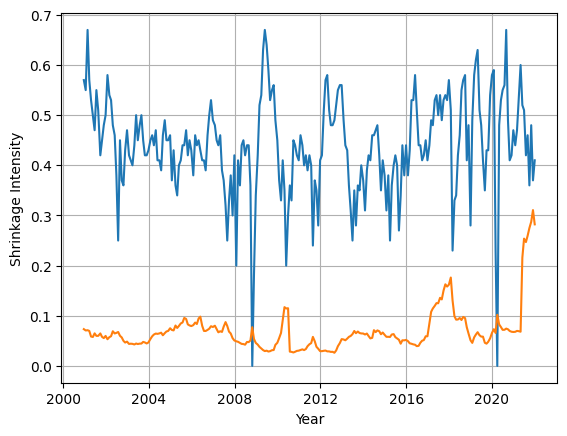

In [44]:
all_res = fixed_shrk_data.iloc[:, 2:].copy() * 100
all_factors = all_res.columns.astype(float).values
Y = all_res.idxmin(axis=1).values.astype(float)
opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))
Y = np.array(re_hf.map_factors_to_preds(Y.reshape(-1), all_factors))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
opt_v3 = np.diag(all_res.loc[:, all_res.idxmin(axis=1).values])[:-21]
opt_v3 = np.insert(arr=opt_v3, obj=0, values=np.repeat(7.0, 21))

rolling_opt = pd.Series(opt_values).rolling(window=252, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=252, min_periods=1).mean().values


ROLL_WINDOW = 252

ROLL_WINDOW_INPUTS = 126
rolling_opt = pd.Series(opt_values).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values
rolling_opt2 = pd.Series(opt_v3).rolling(window=ROLL_WINDOW_INPUTS, min_periods=1).mean().values

Y = pd.Series(Y).rolling(window=21, min_periods=1).mean().astype(np.int64).values
opt_values = pd.Series(opt_values).rolling(window=63, min_periods=1).mean().astype(np.int64).values

params = {
'pf_size' : pf_size,
'opt_values_factors' : opt_values,
'include_ts_momentum_var_allstocks': False,
'include_ts_momentum_allstocks': True,
'include_sample_covmat_trace': True,
'include_mean_of_correls': True,
'include_iqr': False,
'include_factors': False,
'include_ewma_year': False,
'include_ewma_month': True,
'include_ew_year_vola': False,
'include_ew_month_vola': True,
'include_allstocks_year_avgvola': True,
'include_allstocks_month_avgvola': False,
    'additional_inputs' : [opt_v3, rolling_opt, rolling_opt2]  
}

X = re_hf.load_additional_train_data(**params)

res = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=5040, 
                                                    model_params={})
res = [r if r > 0 else 0 for r in res]
res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]

mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
#r = eval_function_new.eval_fct_networkonly_1YR(mapped_res, rets_full, permnos, 0, val_indices_results)
#eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

res_df = pd.DataFrame({"ElasticNet_CVC": mapped_res, "CVC": cov1para_shrk }, index=pd.to_datetime(permnos.index[5040:], format="%Y%m%d") )
res_df = res_df.iloc[list(range(0, 5313, 21)), :]  # because we only may change intensity on every rebalancing date
fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.plot(res_df)
ax.set(xlabel='Year', ylabel='Shrinkage Intensity')
ax.grid()

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100

#### Learning with same 'Y' as for NL Shrinkage

In [45]:
from xgboost import XGBRegressor
def general_single_output_XGB_Lagged(X, Y, len_train, single_train=False, expanding=False, train_size=None, model_params={} ):
    model_predictions = []
    if train_size is None:
        train_size = len_train
    for i in range(X.shape[0] // 21):  # is too long which is why we have a if clause
        if len_train + 21*(i+1) > X.shape[0]:
            model_predictions = np.repeat(model_predictions, 21)
            return model_predictions
        else:  # TRAINING
            if single_train == False:
                if expanding == False:
                    x_train = X[len_train - train_size + 21*i : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size + 21*i : len_train + 21*(i-1), ]
                else:
                    x_train = X[len_train - train_size : len_train + 21*(i-1), :]
                    y_train = Y[len_train - train_size : len_train + 21*(i-1), ]
                regr = XGBRegressor(random_state=123, **model_params)
                regr = regr.fit(x_train, y_train)
            else:
                if i == 0:
                    x_train = X[len_train - train_size + 21 * i: len_train + 21 * (i - 1), :]
                    y_train = Y[len_train - train_size + 21 * i: len_train + 21 * (i - 1), ]
                    regr = XGBRegressor(random_state=123, **model_params)
                    regr = regr.fit(x_train, y_train)
            ## TRAINING DONE
            x_test = X[len_train + 21 * (i - 1):len_train + 21 * i, :]
            x_test = np.ascontiguousarray(X[len_train + 21 * i, :].reshape(1, -1))
            preds = regr.predict(x_test)

            preds = int(np.round(preds, 0))

            print(f"fitted model in iteration {i} out of {5313//21}")
            model_predictions.append(preds)

In [46]:
xgb_params={}
res_xgb = general_single_output_XGB_Lagged(X=X, Y=Y, len_train=5040, model_params=xgb_params)

C:\Users\dkostovic\AppData\Local\Temp\3\ipykernel_11788\2213940639.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  preds = int(np.round(preds, 0))


fitted model in iteration 0 out of 253
fitted model in iteration 1 out of 253
fitted model in iteration 2 out of 253
fitted model in iteration 3 out of 253
fitted model in iteration 4 out of 253
fitted model in iteration 5 out of 253
fitted model in iteration 6 out of 253
fitted model in iteration 7 out of 253
fitted model in iteration 8 out of 253
fitted model in iteration 9 out of 253
fitted model in iteration 10 out of 253
fitted model in iteration 11 out of 253
fitted model in iteration 12 out of 253
fitted model in iteration 13 out of 253
fitted model in iteration 14 out of 253
fitted model in iteration 15 out of 253
fitted model in iteration 16 out of 253
fitted model in iteration 17 out of 253
fitted model in iteration 18 out of 253
fitted model in iteration 19 out of 253
fitted model in iteration 20 out of 253
fitted model in iteration 21 out of 253
fitted model in iteration 22 out of 253
fitted model in iteration 23 out of 253
fitted model in iteration 24 out of 253
fitted mod

H:\all\RL_Shrinkage_2024\helpers\eval_function_new.py:134: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


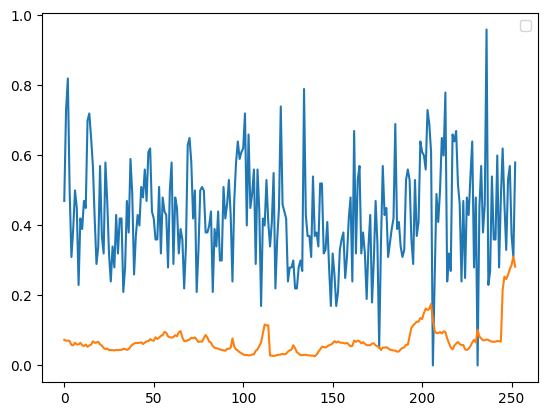

np.float64(24.26577875214317)

In [47]:
res_xgb = [r if r > 0 else 0 for r in res_xgb]
res_xgb = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res_xgb]

mapped_res_xgb = np.array(re_hf.map_preds_to_factors(res_xgb, all_factors)).astype(float)
np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res_xgb]).std()*np.sqrt(252)*100

eval_function_new.myplot(mapped_res_xgb[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])

np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res_xgb]).std()*np.sqrt(252)*100

#### Analysis of the Input Data

In [149]:
#px.line(pd.Series(Y).rolling(21).mean())

### Cross Validation

In [17]:

from sklearn.model_selection import ParameterGrid
model_params_grid = {
    "alpha": [0.5, 1.0, 1.5, 2.0],
    "l1_ratio": [0.25, 0.5, 0.75],
    "max_iter": [500, 1000, 1500, 2000],
    "tol": [1e-3, 1e-4, 1e-5]
}
model_params_grid = list(ParameterGrid(model_params_grid))

for p in model_params_grid:
    res = re_hf.general_single_output_ElasticNet_Lagged(X=X, Y=Y, len_train=len_train, model_params=p)
    #eval_function_new.myplot(mapped_res[val_idxes_shrkges], cov1para_shrk[val_idxes_shrkges])
    res = [r if r > 0 else 0 for r in res]
    res = [r if r < all_factors.shape[0] else all_factors.shape[0]-1 for r in res]
    mapped_res = np.array(re_hf.map_preds_to_factors(res, all_factors)).astype(float)
    x = np.diag(rawres_fixed_shrk_data.iloc[5040:, :].loc[:, mapped_res]).std()*np.sqrt(252)*100
    print(x)
    
    
    


23.563782350210342
23.56377317773434
23.56377317773434
23.563782350210342
23.56377317773434
23.56377317773434
23.563782350210342
23.56377317773434
23.56377317773434
23.563782350210342
23.56377317773434
23.56377317773434
10.466082126687832
10.466082126687832
10.466082126687832
10.466082126687832
10.466082126687832
10.466082126687832
10.466082126687832
10.466082126687832
10.466082126687832
10.466082126687832
10.466082126687832
10.466082126687832
10.463489619581503
10.463489619581503
10.463489619581503
10.463489619581503
10.463489619581503
10.463489619581503
10.463489619581503
10.463489619581503
10.463489619581503
10.463489619581503
10.463489619581503
10.463489619581503
23.565048458571923
23.565048458571923
23.565048458571923
23.565048458571923
23.565048458571923
23.565048458571923
23.565048458571923
23.565048458571923
23.565048458571923
23.565048458571923
23.565048458571923
23.565048458571923
10.466633721533334
10.466633721533334
10.466633721533334
10.466633721533334
10.466633721533334
1

In [15]:
p

{'alpha': 0.5, 'l1_ratio': 0.25, 'max_iter': 500, 'tol': 0.001}

In [169]:
opt_values = all_res.idxmin(axis=1).values.astype(float)[:-21]
opt_values = np.insert(arr=opt_values, obj=0, values=np.repeat(0.15, 21))
opt_values = np.array(re_hf.map_factors_to_preds(opt_values, all_factors))
tmp = opt_values[5040:]

for i in list(range(1,252,2)):
    ROLL_TMP_WINDOW = i
    tmp = pd.Series(tmp).rolling(window=ROLL_TMP_WINDOW, min_periods=1).mean().round(0)
    x = ( np.diag(rawres_fixed_shrk_data.iloc[5040:].iloc[:, tmp]) ).std() * np.sqrt(252) * 100
    print(x)

10.62026345637679
10.554378813890153
10.572962601409252
10.633740508040123
10.678266894425976
10.683818656563702
10.660160843685544
10.674722115590578
10.773255385861003
10.929736637888455
11.039478749713675
11.066468159138978
10.984136516046505
10.856188500509242
10.740593609524685
10.6629878270071
10.629501252257773
10.614258540956898
10.597246629745916
10.586563779720311
10.598245786599326
10.624110751781314
10.62128620264657
10.576611753669871
10.531685866052626
10.524717773554345
10.558107425563849
10.610328951029738
10.649201349764798
10.661304181258922
10.66194642755114
10.660177934397566
10.663897498300308
10.680051777941012
10.70592379218386
10.729804001703029
10.74571639997823
10.751604497820358
10.737494761676771
10.71840192467698
10.694624250345846
10.67541017424199
10.656942143196595
10.652516452122818
10.645676478750708
10.640387477510876
10.632907826731378
10.62901918356844
10.618710529826721
10.613167115402474
10.610668970617123
10.61307809473642
10.61326989592644
10.61

### Get Oracle

In [167]:
minidx = all_res.idxmin(axis=1).values.astype(float)[5040:]
minidx_lagged = all_res.idxmin(axis=1).values.astype(float)[:-21][5040 + 21:]

#np.diag(rawres_fixed_shrk_data.iloc[5040:, ].loc[:, minidx]).std() * np.sqrt(252) * 100

np.diag(rawres_fixed_shrk_data.iloc[5040:, ].loc[:, minidx_lagged]).std() * np.sqrt(252) * 100



np.float64(10.942386562773992)

### Get fixed Intensities Results

In [118]:
pf_sds = {}
pf_means = {}
for PF_SIZE in [30, 50, 100, 225, 500]:
    in_path = rf"H:\all\RL_Shrinkage_2024\ONE_YR\preprocessing\training_dfs\PF{PF_SIZE}\fixed_shrkges_rawres_{fixed_shrk_name}_p{PF_SIZE}.pickle"
    with open(in_path, 'rb') as f:
        all_rawres = pickle.load(f)

    pf_sds[PF_SIZE] = (all_rawres.iloc[5040:, :].std() * np.sqrt(252) * 100).values.round(2)
    pf_means[PF_SIZE] = (all_rawres.iloc[5040:, :].mean() * 252 * 100).values.round(2)

pf_means_df = pd.DataFrame(pf_means).T
pf_means_df.columns = all_rawres.columns

pf_sds_df = pd.DataFrame(pf_sds).T
pf_sds_df.columns = all_rawres.columns

out_path = r"H:\all\RL_Shrinkage_2024\ONE_YR\Linear_Shrinkage\results"

pf_means_df.to_csv(f"{out_path}/AV_fixed_intensity.csv")
pf_sds_df.to_csv(f"{out_path}/SD_fixed_intensity.csv")

In [148]:
pf_sds_df.iloc[:, 20:40]

,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39
30,13.36,13.37,13.38,13.39,13.40,13.41,13.43,13.44,13.46,13.47,13.49,13.51,13.53,13.55,13.57,13.59,13.61,13.63,13.65,13.68
50,13.24,13.24,13.24,13.25,13.25,13.25,13.26,13.26,13.27,13.28,13.29,13.30,13.31,13.32,13.33,13.35,13.36,13.37,13.39,13.41
100,12.60,12.60,12.60,12.59,12.59,12.59,12.60,12.60,12.60,12.61,12.62,12.62,12.63,12.64,12.65,12.66,12.67,12.68,12.70,12.71
225,11.41,11.40,11.39,11.39,11.38,11.38,11.38,11.38,11.38,11.38,11.39,11.39,11.40,11.41,11.41,11.42,11.43,11.44,11.46,11.47
500,10.46,10.45,10.45,10.44,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.43,10.44,10.44,10.45,10.46,10.46,10.47,10.48,10.49


#### sanity check if cov1 para is same results as in my thesis

In [145]:
z = optimal_shrk_data['shrk_factor'].iloc[5040:].values.astype(np.float64).round(2)
np.diag(all_rawres.iloc[5040:, ].loc[:, z]).std() * np.sqrt(252) * 100

np.float64(11.013846795392254)